# N-qubit Teleportation via SWAP gates

This notebook implements a reference experiment where entanglement is transferred from qubit `1` to qubit `n-1` using a chain of SWAP gates, rather than teleportation. The initial state is a Bell pair on qubits `0` and `1`. The SWAP gates are applied as `SWAP(1, 2)`, `SWAP(2, 3)`, ..., `SWAP(n-2, n-1)`, resulting in an entangled pair between `0` and `n-1`.

In [1]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Sequence

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, partial_trace, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    ReadoutError,
    amplitude_damping_error,
    depolarizing_error,
    phase_damping_error,
)
import matplotlib.pyplot as plt

## Noise utilities
The dataclass + helper below keep all noise parameters in one place and build a
matching `NoiseModel` for any simulator we instantiate.

In [2]:
@dataclass
class NoiseParams:
    p_single: float = 2e-3
    p_two: float = 1e-2
    p_readout: float = 1.5e-2
    t1: float = 150e-6
    tphi: float = 200e-6
    gate_time: float = 2e-7


def combined_damping_error(t1=None, tphi=None, gate_time=2e-7):
    """Return a single-qubit error channel for amplitude damping (T1) and pure dephasing (Tphi)."""
    errors = []
    if t1:
        p_amp = 1 - math.exp(-gate_time / t1)
        errors.append(amplitude_damping_error(p_amp))
    if tphi:
        p_phase = 1 - math.exp(-gate_time / tphi)
        errors.append(phase_damping_error(p_phase))

    if not errors:
        return None

    combined = errors[0]
    for err in errors[1:]:
        combined = combined.compose(err)
    return combined


def build_noise_model(params: NoiseParams) -> NoiseModel:
    """Depolarising gate errors + readout flips, identical to the reference notebooks."""
    noise_model = NoiseModel()

    single_depolar = depolarizing_error(params.p_single, 1)
    two_depolar = depolarizing_error(params.p_two, 2)
    readout_error = ReadoutError([[1 - params.p_readout, params.p_readout], [params.p_readout, 1 - params.p_readout]])

    damping = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time)
    if damping is not None:
        single_error = single_depolar.compose(damping)
        two_error = two_depolar.compose(damping.tensor(damping))
    else:
        single_error = single_depolar
        two_error = two_depolar

    single_gate_set = ["id", "x", "sx", "rz", "h"]
    two_gate_set = ["cx", "cz"]  # Removed 'swap' to force decomposition into CX gates

    noise_model.add_all_qubit_quantum_error(single_error, single_gate_set)
    noise_model.add_all_qubit_quantum_error(two_error, two_gate_set)
    noise_model.add_all_qubit_readout_error(readout_error)
    return noise_model

## Circuit construction
`build_swap_circuit` constructs the chain. It creates a Bell pair on (0, 1) and then swaps qubit 1 down the line to qubit N-1.

In [3]:
def bell_pair_density(simulator: AerSimulator) -> DensityMatrix:
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.cx(0, 1)
    circ.save_density_matrix(label="rho_orig")
    compiled = transpile(circ, simulator)
    result = simulator.run(compiled).result()
    return DensityMatrix(result.data(0)["rho_orig"])

def build_swap_circuit(num_qubits: int) -> QuantumCircuit:
    """Return the N-qubit SWAP chain circuit.

    1. Entangle qubits (0,1).
    2. Apply SWAP(1, 2), SWAP(2, 3), ..., SWAP(num_qubits-2, num_qubits-1).
    """
    if num_qubits < 3:
        raise ValueError("Need at least 3 qubits for this experiment")

    circ = QuantumCircuit(num_qubits)

    # 1. Entangle qubits (0,1)
    circ.h(0)
    circ.cx(0, 1)

    # 2. Swap chain
    for q in range(1, num_qubits - 1):
        circ.cx(q, q + 1)
        circ.cx(q+1, q)
        circ.cx(q, q+1)
    circ.save_density_matrix(label="rho_final")
    return circ

## Circuit visualization
Draw the circuit for N=5 to verify the structure.

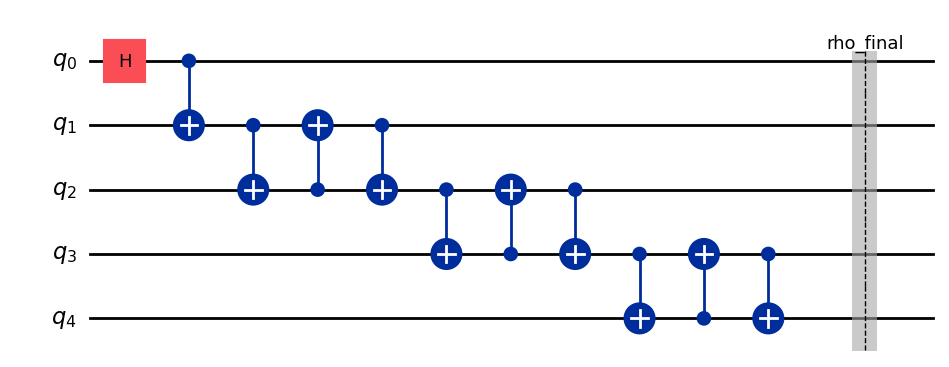

In [4]:
circuit_n5 = build_swap_circuit(5)
circuit_n5.draw('mpl')

## Simulation helpers
Utility functions below trace out irrelevant qubits and evaluate the noisy and
ideal chains so downstream analyses can focus on fidelity numbers.

In [5]:
def reduced_pair(dm: DensityMatrix, keep: Sequence[int]) -> DensityMatrix:
    """Partial trace helper keeping only the requested qubits."""
    keep = sorted(keep)
    num_qubits = dm.num_qubits
    trace_out = [i for i in range(num_qubits) if i not in keep]
    return partial_trace(dm, trace_out)


def simulate_chain(num_qubits: int, simulator: AerSimulator) -> DensityMatrix:
    circuit = build_swap_circuit(num_qubits)
    compiled = transpile(circuit, simulator)
    result = simulator.run(compiled).result()
    rho_full = DensityMatrix(result.data(0)["rho_final"])
    # The Bell pair should end up on qubit 0 and qubit n-1
    return reduced_pair(rho_full, keep=(0, num_qubits - 1))

## Evaluate a single configuration
Choose the number of qubits and noise parameters, then run both ideal and noisy
circuits to print their fidelities versus a perfect Bell pair.

In [6]:
def evaluate_fidelity(num_qubits: int, noise: NoiseParams) -> None:
    """Run both ideal and noisy simulators and print fidelities."""
    ideal_sim = AerSimulator(method="density_matrix")
    noisy_sim = AerSimulator(method="density_matrix", noise_model=build_noise_model(noise))

    rho_ref = bell_pair_density(ideal_sim)
    rho_ideal = simulate_chain(num_qubits, ideal_sim)
    rho_noisy = simulate_chain(num_qubits, noisy_sim)

    print(f"N = {num_qubits}")
    print(noise)
    print("Fidelity (ideal vs reference):", state_fidelity(rho_ref, rho_ideal))
    print("Fidelity (noisy vs reference):", state_fidelity(rho_ref, rho_noisy))

## Test with default parameters

In [7]:
num_qubits = 5
noise = NoiseParams(
    p_single=2e-3,
    p_two=1e-2,
    p_readout=1.5e-2,
    t1=150e-6,
    tphi=200e-6,
    gate_time=2e-7,
)

evaluate_fidelity(num_qubits, noise)

N = 5
NoiseParams(p_single=0.002, p_two=0.01, p_readout=0.015, t1=0.00015, tphi=0.0002, gate_time=2e-07)
Fidelity (ideal vs reference): 1.0000000000000022
Fidelity (noisy vs reference): 0.9162725945657562


## Chain-length sensitivity study
Sweep the total number of qubits to see how the depth of the SWAP chain affects fidelity.


Chain length sensitivity (fixed noise):
  N=3: fidelity=0.963997
  N=4: fidelity=0.939722
  N=5: fidelity=0.916273
  N=6: fidelity=0.893621
  N=7: fidelity=0.871739


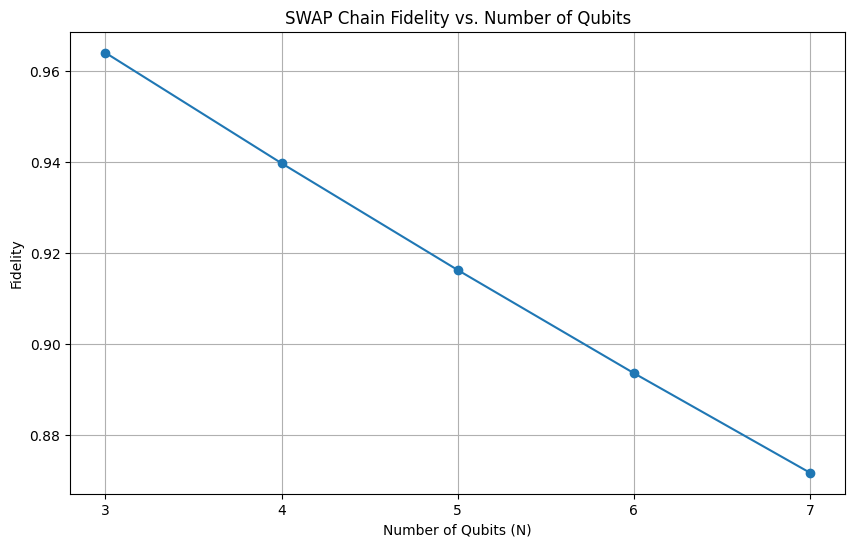

In [8]:
print("\nChain length sensitivity (fixed noise):")
noise_model = build_noise_model(noise)

fidelities = []
N_values = []

for n in range(3, 8):
    ideal_sim = AerSimulator(method="density_matrix")
    noisy_sim = AerSimulator(method="density_matrix", noise_model=noise_model)
    
    rho_ref = bell_pair_density(ideal_sim)
    
    # Optimize by saving only the relevant reduced state
    circ = build_swap_circuit(n)
    if circ.data and circ.data[-1].operation.name == 'save_density_matrix':
        circ.data.pop()
    circ.save_density_matrix(qubits=[0, n - 1], label="rho_pair")
    
    compiled = transpile(circ, noisy_sim)
    result = noisy_sim.run(compiled).result()
    
    rho_noisy = DensityMatrix(result.data(0)["rho_pair"])
    
    fidelity = state_fidelity(rho_ref, rho_noisy)
    fidelities.append(fidelity)
    N_values.append(n)
    
    print(f"  N={n}: fidelity={fidelity:.6f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_values, fidelities, marker='o', linestyle='-')
plt.title("SWAP Chain Fidelity vs. Number of Qubits")
plt.xlabel("Number of Qubits (N)")
plt.ylabel("Fidelity")
plt.grid(True)
plt.xticks(N_values)
plt.show()